In [2]:
import pandas as pd
import re

# 读取文件
with open('humandata.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()

# 存储所有发言（Seeker 和 Supporter）
all_utterances = []
current_conversation = None
utterance_counter = 0  # 每个对话内的 Seeker 发言计数器

# 第一遍：收集所有发言信息
for line in lines:
    line = line.strip()
    
    # 检查是否是对话标题
    conv_match = re.match(r'Conversation (\d+):', line)
    if conv_match:
        current_conversation = int(conv_match.group(1))
        utterance_counter = 0  # 重置计数器
        continue
    
    if not line or current_conversation is None:
        continue
    
    # 检查是否是 Seeker 发言
    seeker_match = re.match(r'\d+\.\s*seeker_\d+:\s*(.+?)(?:\s*—|$)', line)
    if seeker_match:
        utterance_counter += 1
        content = seeker_match.group(1).strip()
        index = f"{current_conversation}.{utterance_counter}"
        all_utterances.append({
            'type': 'seeker',
            'index': index,
            'content': content,
            'conversation': current_conversation
        })
    
    # 检查是否是 Supporter 发言
    supporter_match = re.match(r'supporter_\d+:\s*(.+?)(?:\s*—|$)', line)
    if supporter_match:
        content = supporter_match.group(1).strip()
        all_utterances.append({
            'type': 'supporter',
            'index': None,  # Supporter 没有编号
            'content': content,
            'conversation': current_conversation
        })

# 第二遍：按对话分组，为每个 Seeker 发言找到前后的 Supporter 发言
# 按对话编号分组
conversations = {}
for utt in all_utterances:
    conv_num = utt['conversation']
    if conv_num not in conversations:
        conversations[conv_num] = []
    conversations[conv_num].append(utt)

# 为每个对话内的 Seeker 发言找到前后的 Supporter
data = []
for conv_num in sorted(conversations.keys()):
    conv_utterances = conversations[conv_num]
    for i, utt in enumerate(conv_utterances):
        if utt['type'] == 'seeker':
            # 在当前对话的发言列表中查找前面的 Supporter
            supporter_pre = None
            for j in range(i - 1, -1, -1):
                if conv_utterances[j]['type'] == 'supporter':
                    supporter_pre = conv_utterances[j]['content']
                    break
            
            # 在当前对话的发言列表中查找后面的 Supporter
            supporter_post = None
            for j in range(i + 1, len(conv_utterances)):
                if conv_utterances[j]['type'] == 'supporter':
                    supporter_post = conv_utterances[j]['content']
                    break
            
            data.append({
                'index': utt['index'],
                'content': utt['content'],
                'supporter-pre': supporter_pre if supporter_pre else '',
                'supporter-post': supporter_post if supporter_post else ''
            })

# 创建 DataFrame
df = pd.DataFrame(data)
df.set_index('index', inplace=True)

# 显示结果
print(f"总共提取了 {len(df)} 条 Seeker 发言")
print("\n前10条数据：")
print(df.head(10))
print("\nDataFrame 信息：")
print(df.info())


总共提取了 121 条 Seeker 发言

前10条数据：
                                                 content  \
index                                                      
1.1                                      could be better   
1.2    thank you, I just don't know what else to do t...   
1.3      have tried that but don't even get an interview   
1.4    yes, I do not qualify for unemployment because...   
1.5    it's almost depleted, been out of work now for...   
1.6    family is not being fully supported compared t...   
1.7              but the cost is 7 years of my future???   
1.8    very well put. seems i am being penalised for ...   
1.9                             thank you for your help.   
1.10   say i can't quit until we have exchanged 10 me...   

                                           supporter-pre  \
index                                                      
1.1                                                        
1.2    I am sorry to hear that. Would you like to tal...   
1.3    S

In [3]:
# 显示每个对话的发言数量
print("每个对话的 Seeker 发言数量：")
conversation_counts = {}
for idx in df.index:
    conv_num = idx.split('.')[0]
    conversation_counts[conv_num] = conversation_counts.get(conv_num, 0) + 1

for conv_num in sorted(conversation_counts.keys(), key=int):
    print(f"Conversation {conv_num}: {conversation_counts[conv_num]} 条发言")

# 显示完整的 DataFrame
print("\n完整的 DataFrame：")
print(df)


每个对话的 Seeker 发言数量：
Conversation 1: 10 条发言
Conversation 2: 24 条发言
Conversation 3: 26 条发言
Conversation 4: 11 条发言
Conversation 5: 13 条发言
Conversation 6: 12 条发言
Conversation 7: 10 条发言
Conversation 8: 15 条发言

完整的 DataFrame：
                                                 content  \
index                                                      
1.1                                      could be better   
1.2    thank you, I just don't know what else to do t...   
1.3      have tried that but don't even get an interview   
1.4    yes, I do not qualify for unemployment because...   
1.5    it's almost depleted, been out of work now for...   
...                                                  ...   
8.11       how do i even begin to start the conversation   
8.12                yeah i told my twin sister, actually   
8.13   definitely. we go to different schools but we ...   
8.14   yha she's better at breaking bad news than i d...   
8.15   yeah. well i feel much better about this. than...   



In [4]:
# 1. 保存 df 到 CSV
df.to_csv('utterances.csv')
print("已保存 utterances.csv")
print(f"共 {len(df)} 条 utterance")

已保存 utterances.csv
共 121 条 utterance


In [5]:
# 2. 读取 annotator.csv 并创建 Human aggregate
annotator_df = pd.read_csv('annotator.csv', index_col=0)

# 创建 Human aggregate: 如果 annotator1 或 annotator2 有一个是 1，则为 1
annotator_df['human_aggregate'] = ((annotator_df['annotator1'] == 1) | (annotator_df['annotator2'] == 1)).astype(int)

print("Annotator DataFrame 前10行：")
print(annotator_df.head(10))
print(f"\nHuman aggregate 统计：")
print(annotator_df['human_aggregate'].value_counts())


Annotator DataFrame 前10行：
     gpt5  annotator1  annotator2  human_aggregate
1.1     0           0           0                0
1.2     0           0           0                0
1.3     0           0           0                0
1.4     0           0           0                0
1.5     1           0           0                0
1.6     0           0           0                0
1.7     1           1           1                1
1.8     1           1           1                1
1.9     0           0           0                0
1.1     0           0           0                0

Human aggregate 统计：
human_aggregate
0    85
1    36
Name: count, dtype: int64


In [6]:
# 3. 找出 GPT-5 认为是 1 但 Human 认为是 0 的条目
gpt5_yes_human_no = annotator_df[(annotator_df['gpt5'] == 1) & (annotator_df['human_aggregate'] == 0)]

print(f"GPT-5 认为是 soundboarding (1) 但 Human 不认为是 (0) 的数量: {len(gpt5_yes_human_no)}")
print(f"\n这些条目的索引：")
print(gpt5_yes_human_no.index.tolist())
print(f"\n前10条：")
print(gpt5_yes_human_no.head(10))

# 确保索引是字符串格式
gpt5_yes_human_no.index = gpt5_yes_human_no.index.astype(str)


GPT-5 认为是 soundboarding (1) 但 Human 不认为是 (0) 的数量: 25

这些条目的索引：
[1.5, 2.3, 2.4, 2.1, 2.12, 2.15, 4.1, 4.3, 4.5, 4.7, 5.2, 5.5, 5.8, 5.9, 5.1, 5.11, 5.12, 6.2, 6.8, 7.4, 7.6, 8.1, 8.5, 8.8, 8.9]

前10条：
      gpt5  annotator1  annotator2  human_aggregate
1.50     1           0           0                0
2.30     1           0           0                0
2.40     1           0           0                0
2.10     1           0           0                0
2.12     1           0           0                0
2.15     1           0           0                0
4.10     1           0           0                0
4.30     1           0           0                0
4.50     1           0           0                0
4.70     1           0           0                0


In [7]:
# 4. 合并 utterance 内容和 annotator 数据
# 只保留 GPT-5 认为是 1 但 Human 认为是 0 的条目

# 确保索引类型一致（都转为字符串）
df.index = df.index.astype(str)

# 检查 df 是否包含必要的列
print("检查 df 的列：")
print(f"df 的列: {df.columns.tolist()}")
print(f"df 是否有 supporter-pre: {'supporter-pre' in df.columns}")
print(f"df 是否有 supporter-post: {'supporter-post' in df.columns}")

# 检查索引匹配情况
print("\n检查索引匹配情况：")
print(f"gpt5_yes_human_no 的索引示例: {gpt5_yes_human_no.index[:5].tolist()}")
print(f"df 的索引示例: {df.index[:5].tolist()}")
print(f"共同索引数量: {len(gpt5_yes_human_no.index.intersection(df.index))}")

# 检查哪些索引在 gpt5_yes_human_no 中但不在 df 中
missing_in_df = gpt5_yes_human_no.index.difference(df.index)
if len(missing_in_df) > 0:
    print(f"\n警告：以下索引在 gpt5_yes_human_no 中但不在 df 中: {missing_in_df.tolist()}")

# 合并数据
merged_df = gpt5_yes_human_no.merge(df, left_index=True, right_index=True, how='left')

# 检查合并结果
print(f"\n合并后缺失 content 的数量: {merged_df['content'].isna().sum()}")
if 'supporter-pre' in merged_df.columns:
    print(f"合并后缺失 supporter-pre 的数量: {merged_df['supporter-pre'].isna().sum()}")
if 'supporter-post' in merged_df.columns:
    print(f"合并后缺失 supporter-post 的数量: {merged_df['supporter-post'].isna().sum()}")

# 重新排列列的顺序，让 content 和上下文在前面
if 'supporter-pre' in merged_df.columns and 'supporter-post' in merged_df.columns:
    merged_df = merged_df[['content', 'supporter-pre', 'supporter-post', 'gpt5', 'annotator1', 'annotator2', 'human_aggregate']]
else:
    # 如果列不存在，只包含 content
    print("\n警告：df 中可能没有 supporter-pre 和 supporter-post 列")
    print("请先运行更新后的 Cell 0 来生成包含这些列的 df")
    merged_df = merged_df[['content', 'gpt5', 'annotator1', 'annotator2', 'human_aggregate']]

print(f"\n合并后的 DataFrame 形状: {merged_df.shape}")
print(f"\n前10条数据：")
print(merged_df.head(10))

# 保存到新 CSV
merged_df.to_csv('gpt5_yes_human_no.csv')
print(f"\n已保存到 gpt5_yes_human_no.csv，共 {len(merged_df)} 条记录")


检查 df 的列：
df 的列: ['content', 'supporter-pre', 'supporter-post']
df 是否有 supporter-pre: True
df 是否有 supporter-post: True

检查索引匹配情况：
gpt5_yes_human_no 的索引示例: ['1.5', '2.3', '2.4', '2.1', '2.12']
df 的索引示例: ['1.1', '1.2', '1.3', '1.4', '1.5']
共同索引数量: 25

合并后缺失 content 的数量: 0
合并后缺失 supporter-pre 的数量: 0
合并后缺失 supporter-post 的数量: 0

合并后的 DataFrame 形状: (25, 7)

前10条数据：
                                                content  \
1.5   it's almost depleted, been out of work now for...   
2.3   I am badly in need of a haircut due to the pan...   
2.4   oh really? how long did it take you to get up ...   
2.1                                               Hello   
2.12  its hard I'm getting older now (50's) and its ...   
2.15                        You know you're right there   
4.1   feeling really stressed out and exhausted tryi...   
4.3   thank you for that. i just wish i either had m...   
4.5   and i desperately need to move out of the situ...   
4.7   i have been looking for work from home jo

In [8]:
# 任务1: 统计每个 seeker 的 utterance 数量
import pandas as pd
import re
from sklearn.metrics import cohen_kappa_score, f1_score, precision_score, recall_score, accuracy_score

score_df = pd.read_csv('score.csv')

# 从 utterance_index 中提取 seeker ID (例如: seeker_5_1 -> seeker_5)
score_df['seeker_id'] = score_df['utterance_index'].str.extract(r'(seeker_\d+)')

# 统计每个 seeker 的 utterance 数量
seeker_counts = score_df['seeker_id'].value_counts().sort_index()

print("每个 Seeker 的 utterance 数量：")
print(seeker_counts)
print(f"\n总共有 {len(seeker_counts)} 个不同的 Seeker")
print(f"总共有 {len(score_df)} 条 utterance")


每个 Seeker 的 utterance 数量：
seeker_id
seeker_1001    24
seeker_1125    12
seeker_1223    10
seeker_123     15
seeker_324     13
seeker_5       10
seeker_523     26
seeker_632     11
Name: count, dtype: int64

总共有 8 个不同的 Seeker
总共有 121 条 utterance


In [26]:
# 5. 读取 prompt_pre.txt 和 gpt5_yes_human_no.csv，生成完整的 prompt iteration 文件
with open('prompt_pre.txt', 'r', encoding='utf-8') as f:
    original_prompt = f.read()

# 读取误分类数据
misclassified_df = pd.read_csv('gpt5_yes_human_no.csv', index_col=0)

# 生成数据表格的文本表示
table_rows = []
for idx, row in misclassified_df.iterrows():
    table_rows.append(f"""
Index: {idx}
Seeker Utterance: {row['content']}
Supporter Before: {row['supporter-pre'] if pd.notna(row['supporter-pre']) and row['supporter-pre'] != '' else '(none)'}
Supporter After: {row['supporter-post'] if pd.notna(row['supporter-post']) and row['supporter-post'] != '' else '(none)'}
LLM Label: {row['gpt5']}
Human Annotator 1: {row['annotator1']}
Human Annotator 2: {row['annotator2']}
---""")

data_table = "\n".join(table_rows)

# 读取 prompt_iteration.txt 模板
with open('prompt_iteration.txt', 'r', encoding='utf-8') as f:
    prompt_template = f.read()

# 替换占位符
final_prompt = prompt_template.replace(
    "[Insert the content from prompt_pre.txt here]",
    original_prompt
).replace(
    "I will provide the table of 25 misclassified cases in the next message.",
    f"Here is the table of 25 misclassified cases:\n\n{data_table}"
)

# 保存完整 prompt
with open('prompt_iteration_full.txt', 'w', encoding='utf-8') as f:
    f.write(final_prompt)

print("已生成完整的 prompt_iteration_full.txt")
print(f"包含 {len(misclassified_df)} 个误分类案例")


已生成完整的 prompt_iteration_full.txt
包含 25 个误分类案例


In [13]:
# 直接写代码更新annotator.csv,增加annotator_aggregate
# aggregate是至少有一个human是1那就是1

import pandas as pd

# 读取 annotator.csv
annotator_df = pd.read_csv('annotator.csv')

# 确保 annotator1 和 annotator2 都是数值（有些部分可能是字符串）
annotator_df['annotator1'] = pd.to_numeric(annotator_df['annotator1'], errors='coerce')
annotator_df['annotator2'] = pd.to_numeric(annotator_df['annotator2'], errors='coerce')

# annotator_aggregate: 只要有一个annotator为1就为1，否则为0
annotator_df['annotator_aggregate'] = ((annotator_df['annotator1'] == 1) | (annotator_df['annotator2'] == 1)).astype(int)

# 保存更新后的 annotator.csv
annotator_df.to_csv('annotator.csv', index=False)
print("已更新 annotator.csv，添加 annotator_aggregate 列（有一人为1即为1）")



已更新 annotator.csv，添加 annotator_aggregate 列（有一人为1即为1）


In [14]:
# 找出annotator_aggregate为0但gpt5为1的数据行，并统计有多少行
count = ((annotator_df['annotator_aggregate'] == 0) & (annotator_df['gpt5'] == 1)).sum()
print(f"annotator_aggregate为0但gpt5为1的共有{count}个")


annotator_aggregate为0但gpt5为1的共有25个


In [15]:
import numpy as np

# 假设annotator_df已存在（上一cell读取并处理过）

thresholds = np.arange(0, 1.01, 0.1)  # 包括1.0

for t in thresholds:
    col_name = f"label_{t:.1f}"
    if np.isclose(t, 0.0):
        # threshold为0时，严格大于0才为1
        annotator_df[col_name] = (annotator_df['score'] > 0).astype(int)
    else:
        # threshold>=的时候为1，否则为0
        annotator_df[col_name] = (annotator_df['score'] >= t).astype(int)

# 保存带新columns的csv（可选，如果不需要可注释掉）
annotator_df.to_csv('annotator.csv', index=False)
print("已基于score按不同threshold（0~1,步长0.1）生成label_threshold列")


已基于score按不同threshold（0~1,步长0.1）生成label_threshold列


In [16]:
# 读取 annotator.csv（包含所有 threshold labels）
df = pd.read_csv("annotator.csv", index_col="utterance_index")

# 获取所有 threshold columns
threshold_cols = [f"label_{t:.1f}" for t in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]]

# 定义评估函数
def calculate_metrics(y_true, y_pred):
    """计算 kappa, f1, precision, recall, accuracy"""
    kappa = cohen_kappa_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    # zero_division参数的作用是在计算precision时，如果分母为0（即预测为正的样本数为0），
    # 此时会导致精确率无法定义（通常会抛出异常或返回NaN）。
    # 设置zero_division=0表示遇到这种情况时返回0而不是报错或返回NaN。
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    return {
        "kappa": kappa,
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "accuracy": accuracy
    }

# 存储所有结果
results = []

# 1. 计算 annotator_aggregate 和每个 threshold 的指标
for threshold_col in threshold_cols:
    if threshold_col in df.columns:
        metrics = calculate_metrics(df["annotator_aggregate"], df[threshold_col])
        results.append({
            "comparison": f"annotator_aggregate_vs_{threshold_col}",
            "threshold": threshold_col,
            **metrics
        })

# 2. 计算 annotator1 和 annotator2 之间的指标
metrics_human = calculate_metrics(df["annotator1"], df["annotator2"])
results.append({
    "comparison": "annotator1_vs_annotator2",
    "threshold": "N/A",
    **metrics_human
})

# 创建结果 DataFrame
agreement_df = pd.DataFrame(results)
agreement_df.set_index("comparison", inplace=True)

# 保存到 CSV
agreement_df.to_csv("agreement.csv")

print("已生成 agreement.csv")
print("\n评估结果：")
print(agreement_df.round(3))

已生成 agreement.csv

评估结果：
                                  threshold  kappa     f1  precision  recall  \
comparison                                                                     
annotator_aggregate_vs_label_0.0  label_0.0  0.121  0.511      0.343   1.000   
annotator_aggregate_vs_label_0.1  label_0.1  0.121  0.511      0.343   1.000   
annotator_aggregate_vs_label_0.2  label_0.2  0.181  0.528      0.371   0.917   
annotator_aggregate_vs_label_0.3  label_0.3  0.303  0.562      0.450   0.750   
annotator_aggregate_vs_label_0.4  label_0.4  0.303  0.562      0.450   0.750   
annotator_aggregate_vs_label_0.5  label_0.5  0.364  0.578      0.511   0.667   
annotator_aggregate_vs_label_0.6  label_0.6  0.421  0.552      0.727   0.444   
annotator_aggregate_vs_label_0.7  label_0.7  0.435  0.538      0.875   0.389   
annotator_aggregate_vs_label_0.8  label_0.8  0.435  0.538      0.875   0.389   
annotator_aggregate_vs_label_0.9  label_0.9  0.286  0.364      1.000   0.222   
annotator_aggre

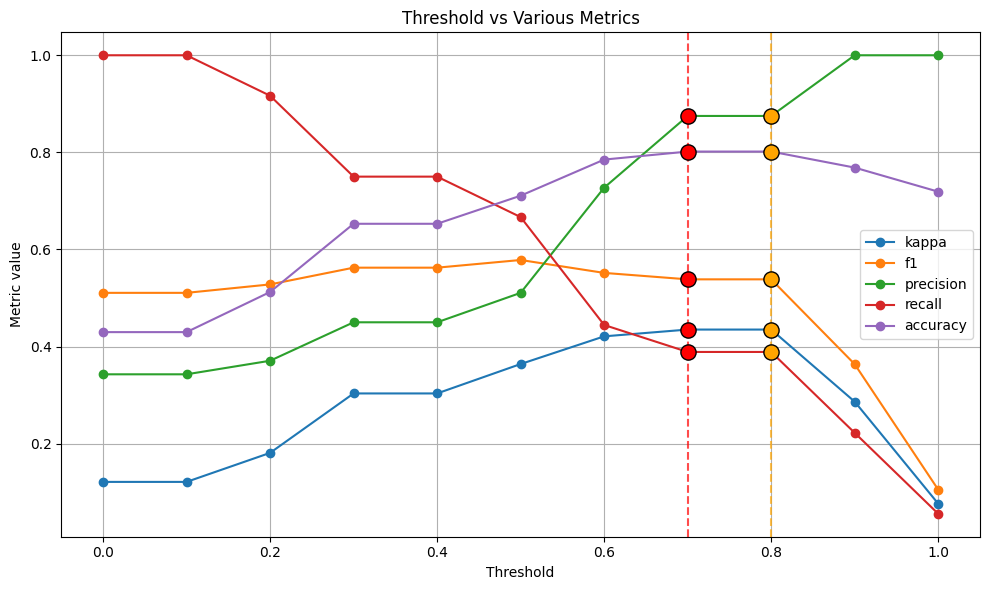

In [20]:
import matplotlib.pyplot as plt

# 选取所有0.0到1.0的threshold列
metric_names = ["kappa", "f1", "precision", "recall", "accuracy"]
thresholds = []
metrics_by_name = {m: [] for m in metric_names}

for threshold_col in threshold_cols:
    if threshold_col in df.columns:
        thresholds.append(float(threshold_col.replace("label_", "")))
        # 在results中寻找对应的记录
        for r in results:
            if r.get("threshold", "") == threshold_col:
                for m in metric_names:
                    metrics_by_name[m].append(r.get(m, None))

# 按阈值升序排序
sort_idx = sorted(range(len(thresholds)), key=lambda i: thresholds[i])
thresholds_sorted = [thresholds[i] for i in sort_idx]
for m in metric_names:
    metrics_by_name[m] = [metrics_by_name[m][i] for i in sort_idx]

plt.figure(figsize=(10, 6))
for m in metric_names:
    plt.plot(thresholds_sorted, metrics_by_name[m], marker="o", label=m)

plt.xlabel("Threshold")
plt.ylabel("Metric value")
plt.title("Threshold vs Various Metrics")
plt.legend()
plt.grid(True)
plt.tight_layout()
# Highight thresholds 0.7 and 0.8
highlight_thresholds = [0.7, 0.8]
colors = ["red", "orange"]

for ht, color in zip(highlight_thresholds, colors):
    if ht in thresholds_sorted:
        idx = thresholds_sorted.index(ht)
        plt.axvline(ht, color=color, linestyle="--", alpha=0.7)
        # 高亮点
        for m in metric_names:
            y_val = metrics_by_name[m][idx]
            plt.scatter(ht, y_val, color=color, s=120, edgecolor="black", zorder=5)

plt.show()


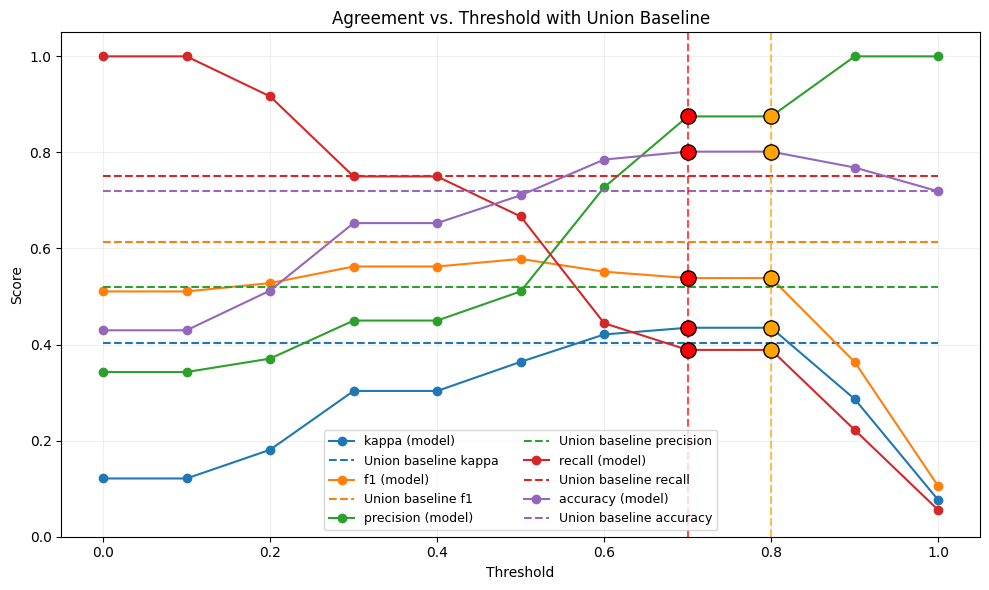

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# 这是ipynb的一个cell，因此无需定义main函数，也无需加__main__保护

# 读取agreement.csv并筛选annotator_aggregate与不同threshold的对比
df = pd.read_csv("agreement.csv")
agg_df = df[df["comparison"].str.contains("annotator_aggregate_vs_label", na=False)].copy()
if agg_df.empty:
    raise ValueError("agreement.csv中未找到annotator_aggregate_vs_label相关记录")

# 从comparison字段提取threshold数值（comparison形如annotator_aggregate_vs_label_0.3）
agg_df["threshold_value"] = (
    agg_df["comparison"].str.extract(r"([0-9]+\.[0-9]+)").astype(float)
)
agg_df = agg_df.sort_values("threshold_value")

metrics = ["kappa", "f1", "precision", "recall", "accuracy"]
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# screenshot第一行（Union recall-oriented）的指标作为baseline
union_baseline = {
    "kappa": 0.404,
    "f1": 0.614,
    "precision": 0.519,
    "recall": 0.75,
    "accuracy": 0.719,
}

plt.figure(figsize=(10, 6))
xmin, xmax = agg_df["threshold_value"].min(), agg_df["threshold_value"].max()

for color, metric in zip(colors, metrics):
    plt.plot(
        agg_df["threshold_value"], agg_df[metric],
        marker="o", color=color, label=f"{metric} (model)"
    )
    plt.hlines(
        union_baseline[metric], xmin, xmax,
        colors=color, linestyles="dashed",
        label=f"Union baseline {metric}"
    )

# --------- 以下为高亮部分（模仿截图） ----------
highlight_thresholds = [0.7, 0.8]
highlight_colors = ["red", "orange"]

for ht, hcolor in zip(highlight_thresholds, highlight_colors):
    if ht in agg_df["threshold_value"].values:
        idx = agg_df[agg_df["threshold_value"] == ht].index[0]
        plt.axvline(ht, color=hcolor, linestyle="--", alpha=0.7)
        # 为每个metric在这个threshold画大圆点
        for color, metric in zip(colors, metrics):
            y_val = agg_df.loc[idx, metric]
            plt.scatter(ht, y_val, color=hcolor, s=120, edgecolor="black", zorder=5)

plt.title("Agreement vs. Threshold with Union Baseline")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(alpha=0.2)
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()
